In [15]:
import pandas as pd
import seaborn as sns
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler, ParameterGrid
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.simplefilter('ignore')
import joblib
import shap

In [5]:
!pip show joblib

Name: joblib
Version: 1.0.1
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /home/sl/.local/share/virtualenvs/hw1-tubLg8CO/lib/python3.8/site-packages
Requires: 
Required-by: scikit-learn


# Данные

In [7]:
def log_proc(s):
    return np.log(s)

def log_unproc(s):
    return np.exp(s)

def rmsle_lgbm(y_pred, data):
    y_true = log_unproc(np.array(data.get_label()))
    y_pred = log_unproc(y_pred)
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))
    return 'rmsle', score, False

In [8]:
train = pd.read_csv('../data/train.csv')

In [9]:
train.sample(5)

Password  Times
2290849            I5P4321      1
2441390           63752792      4
3419996          loner2000      1
2809777  corvettetommydeal      1
3092619            saruris      1

# Фичи

In [10]:
def preproc(df):
    df['len'] = df['Password'].str.len().fillna(0).astype(int)
    df['have_num'] = df['Password'].str.contains('\d').fillna(0).astype(int)
    df['cnt_num'] = df['Password'].str.count('\d').fillna(0).astype(int)
    df['have_up_case'] = df['Password'].str.contains('[A-Z]').fillna(0).astype(int)
    df['cnt_up_case'] = df['Password'].str.count('[A-Z]').fillna(0).astype(int)
    df['have_low_case'] = df['Password'].str.contains('[a-z]').fillna(0).astype(int)
    df['cnt_low_case'] = df['Password'].str.count('[a-z]').fillna(0).astype(int)
    df['have_spec'] = (df['Password'].str.contains('^\w+$').fillna(0) == False).astype(int)
    df['cnt_spec'] = df['len'] - df['cnt_num'] - df['cnt_up_case'] - df['cnt_low_case']
    df['len_eq_num'] = (df['len'] == df['cnt_num']).astype(int)
    df['len_eq_up_case'] = (df['len'] == df['cnt_up_case']).astype(int)
    df['len_eq_low_case'] = (df['len'] == df['cnt_low_case']).astype(int)
    
    df['len_8'] = 0
    df.loc[df['len']==8,'len_8'] = 1
    df['isdigit']=df['Password'].fillna(0).str.isdigit().fillna(0).astype(int)
    df['d_b'] = (df['isdigit']==1)&(df['len_8']==1).astype(int)
    df['d_b_y'] = df[df['d_b']==1]['Password'].str[4:].astype(int)
    df['d_b_y'].fillna(0,inplace=True)
    df['d_b_y'] =df['d_b_y'].astype(int)
    df.loc[(df['d_b_y']<1960)|(df['d_b_y']>2010),'d_b_y'] = 0
    df.drop('d_b',axis=1,inplace=True)

    return df

In [11]:
print('- Препроцессинг')
train['Times'] = log_proc(train['Times'])
train = preproc(train)
print('- Разбиение данных')
feat = list(train.columns[2:])

- Препроцессинг
- Разбиение данных


In [12]:
X_train, X_test, y_train, y_test = train_test_split(train[feat], train['Times'], test_size = 0.2)
train_set = lgbm.Dataset(X_train, y_train)
valid_set = lgbm.Dataset(X_test, y_test)

# Модель

In [13]:
print('- Обучение')
params = {
    'max_depth': range(4,11+1),
    'learning_rate': np.logspace(-2,-1,10)}
ps = list(ParameterSampler(params, n_iter=3, random_state=42))
ps.sort(key=lambda row: (row['max_depth'],row['learning_rate']), reverse=False) 

best_score = 100
best_model = None

for p in ps:
    md = p['max_depth']
    lr = p['learning_rate']
    
    param = {
        'objective': 'regression',
        'n_jobs': 5,
        'verbose': -1,
        'max_depth': md,
        'learning_rate': lr}

    bst = lgbm.train(
        param, 
        train_set,
        valid_sets = valid_set,
        early_stopping_rounds = 30,
        num_boost_round = 2000,
        feval = rmsle_lgbm,
        verbose_eval = None
    )
    
    best_iter = bst.best_iteration
    score = bst.best_score['valid_0']['rmsle']
    
    if score < best_score:
        best_score = score
        best_score_mark = '<--'
        best_model = bst
    else:
        best_score_mark = ''
    
    print(f'md:', md, '| lr:', round(lr,4), '| iter:', best_iter, '| score:', round(score,5), best_score_mark)

- Обучение
md: 4 | lr: 0.01 | iter: 1833 | score: 0.37254 <--
md: 10 | lr: 0.0167 | iter: 727 | score: 0.37251 <--
md: 10 | lr: 0.0215 | iter: 566 | score: 0.37251 <--


In [16]:
explainer = shap.Explainer(best_model.predict, X_test)

In [17]:
joblib.dump(explainer, "explainer2.joblib")

['explainer2.joblib']

# Предсказание

In [51]:
test = pd.read_csv('Xtest.csv', index_col='Id')

In [52]:
test = preproc(test)
X_test = test[feat]

In [53]:
10**train[train['d_b_y']==1979]['Times']

995        42.0
5963       30.0
10764      44.0
26896       1.0
41059       1.0
           ... 
4123504     2.0
4142886     3.0
4143677    42.0
4147212    33.0
4150215    37.0
Name: Times, Length: 420, dtype: float64

In [54]:
sub = X_test[[]]
sub['Times'] = bst.predict(X_test)
sub['Times'] = 10**sub['Times']
sub.head()

Times
Id          
0   1.057694
1   1.081171
2   1.025300
3   1.232985
4   1.412259

In [55]:
sub.to_csv('sub3_fin.csv')

In [3]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
X100.iloc[[0]]

CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  RAD    TAX  \
172  0.13914  0.0   4.05   0.0  0.51  5.572  88.5  2.5961  5.0  296.0   

     PTRATIO      B  LSTAT  
172     16.6  396.9  14.69

In [22]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X.iloc[[0]])

In [23]:
shap_values

.values =
array([[ 3.76612501e-01,  2.57401442e-01, -1.68850054e-01,
        -1.61204029e-01,  2.34341602e-01,  1.17031439e+00,
        -1.46543956e-03, -4.24775855e-01, -2.62284403e+00,
         1.29685920e+00,  2.97161862e+00,  2.96337802e-01,
         3.93810172e+00]])

.base_values =
array([22.84139551])

.data =
array([[6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
        6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
        4.980e+00]])

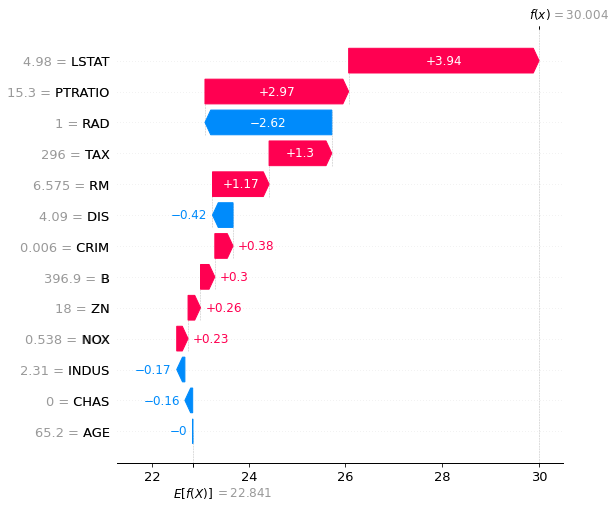

In [24]:
shap.plots.waterfall(shap_values[0], max_display=14)